In [137]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
import string
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from yellowbrick.classifier import confusion_matrix

In [126]:
df = pd.read_csv('tweets_processados.csv')
df = df.dropna()
df = df.drop_duplicates(['Text'])

#### Função de limpar os tweets

In [127]:
#retirar pontuações e stopwords pois não são relevantes para o modelo
def clean_text(text_list):
    #recebe uma lista de strings
    twitter_punct = '!"$\'*+,-./?`{|}~%:'
    clean_text_list = []
    for text in text_list:
        
        #pontuações
        text_sempont = [char for char in text if char not in twitter_punct]
        text_sempont = ''.join(text_sempont)

        #remover links
        text_semlink = re.sub('https\S+', '', text_sempont)

        #stopwords
        text_process = [word for word in text_semlink.split() 
                        if word.lower() not in stopwords.words('portuguese')]
        text_process = ' '.join(text_process)
        
        clean_text_list.append(text_process)
        
    #retorna uma lista de strings limpa
    return clean_text_list

#### Temos os tweets e as classificações processadas e prontas para treino na pipeline

In [128]:
tweets = df.Text
classes = df.Classificacao

#### Criar e fitar os modelos, usando uma Pipeline para tornar o preprocessamento mais rápido

In [129]:
#criação da pipeline - Naive Bayes
pipeline_nb = Pipeline([
    ('vectorizer', CountVectorizer(tokenizer=TweetTokenizer().tokenize)),
    ('tf-idf', TfidfTransformer()),
    ('Naive Bayes', MultinomialNB())
])

In [130]:
#criação da pipeline - Random Forest
pipeline_rfc = Pipeline([
    ('vectorizer', CountVectorizer(tokenizer=TweetTokenizer().tokenize)),
    ('tf-idf', TfidfTransformer()),
    ('Random Forest', RandomForestClassifier())
])

In [131]:
#criação da pipeline - SVM
pipeline_svm = Pipeline([
    ('vectorizer', CountVectorizer(tokenizer=TweetTokenizer().tokenize)),
    ('tf-idf', TfidfTransformer()),
    ('SVM', SVC())
])

#### Avalianção do modelo

In [132]:
#Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(tweets, classes, test_size=0.2)

In [133]:
def validacao(model, X, y):
    kfold = KFold(n_splits=5, shuffle=True)
    score = cross_val_score(model, X, y, cv=kfold)
    return round(np.mean(score), 4)

print('Score Naive Bayes: ', validacao(pipeline_nb, X_train, y_train) * 100, '%',
      '\nScore RandomForest: ', validacao(pipeline_rfc, X_train, y_train) * 100, '%',
      '\nScore SVM: ', validacao(pipeline_svm, X_train, y_train) * 100, '%')

Score Naive Bayes:  76.48 % 
Score RandomForest:  74.11 % 
Score SVM:  77.34 %


In [134]:
pipeline_nb.fit(X_train, y_train)
preds = pipeline_nb.predict(X_test)
preds[:10]

array(['Positivo', 'Positivo', 'Negativo', 'Negativo', 'Positivo',
       'Negativo', 'Positivo', 'Positivo', 'Positivo', 'Positivo'],
      dtype='<U8')

#### Visualização dos acertos por categoria

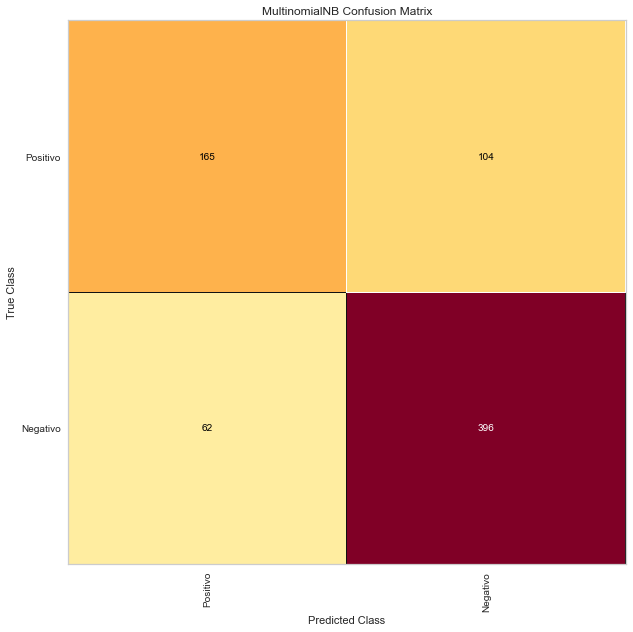

<Figure size 432x288 with 0 Axes>

In [135]:
#instantiate the visualizer with the classification model
plt.figure(figsize=(10, 10))
confusion_matrix(pipeline_nb,
                 X_train, y_train, X_test, y_test, 
                 classes=['Positivo', 'Negativo'],)

plt.tight_layout()

#### Curva ROC

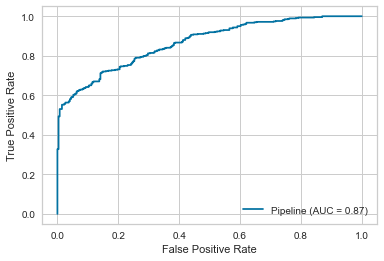

In [138]:
plot_roc_curve(pipeline_nb, X_test, y_test)

In [136]:
#teste da pipeline com um exemplo
tweets_teste = ['A nova cédula deverá entrar em circulação a partir do final de agosto.',
                'Não consigo ver nem a de 100, imagina quando vou ter uma de 200..…..mas gostei! =)',
                'É bem ruim, demostra a desvalorização do real.',
                'Vergonha. Decisao Imbecil em Plena Pandemia.',
                'O cachorro-vinagre seria mais fofinho, imagina']

tweets_clean = clean_text(tweets_teste)

predictions = pipeline_nb.predict(tweets_clean)

for t, p in zip(tweets_teste, predictions):
    print(t, '\nPredição: ', p, '\n')

A nova cédula deverá entrar em circulação a partir do final de agosto. 
Predição:  Positivo 

Não consigo ver nem a de 100, imagina quando vou ter uma de 200..…..mas gostei! =) 
Predição:  Positivo 

É bem ruim, demostra a desvalorização do real. 
Predição:  Positivo 

Vergonha. Decisao Imbecil em Plena Pandemia. 
Predição:  Negativo 

O cachorro-vinagre seria mais fofinho, imagina 
Predição:  Positivo 



#### Possiveis problemas no modelo:
    1. alguma pontuação pode estar atrapalhando o modelo, não foram retiradas todas pois podem existir emojis nos tweets.
    2. poucos dados, podem ser insuficientes para o modelo.
    3. modelo prevendo muitos falsos negativos, que deveriam ser positivos.
    4. tfidf dando maior importancia para palavras que representam locais
   
#### Possiveis soluções:
    1. utilizar tecnicas como stemming e lemmatization
    2. procurar especificamente por emojis no preprocessamento
    3. obter dados em maior quantidade e diversidade
    4. treinar um modelo mais robusto, como por exemplo uma rede neural